<br><br>
<font size='6'><b>Domain adaptation
</b></font><br><br>

<br>
<div class=pull-right>
By Prof. Hyunseok OH<br>
https://sddo.gist.ac.kr/<br>
SDDO Lab at GIST
</div>

**Table of Contents**

* [1. Import library](#section1)  
* [2. Data preparation](#section2)  
    * [2.1 Immediate use of pre-trained model](#section2.1)  
    * [2.2 Normalization Information](#section2.2)  
* [3. Train baseline CNN](#section3)  
    * [3.1 Baseline model, loss, optimizer, metrics](#section3.1)      
    * [3.2 Train and Test function](#section3.2)   
    * [3.3 Train on MNIST](#section3.3)           
* [4. Domain adversarial neural network](#section4)    
    * [4.1 Domain adversarial neural network model, loss, optimizer, metrics](#section4.1)  
    * [4.2 Domain label generation](#section4.2)  
    * [4.3 Train and Test function](#section4.3)  
    * [4.4 Train  with MNIST and SVHN](#section4.4)  

<img src="https://github.com/MinseokOff/KSME_advanced/blob/main/Pre_trained/domain_adaptation.png?raw=true" width="700"/>  
* 소스 도메인의 정보를 타겟 도메인에 적응시켜 예측 성능 향상
* Feature space 상에서 도메인 간 데이터의 관계를 사용

### Domain adversarial neural net (DANN)
<img src="https://github.com/MinseokOff/KSME_advanced/blob/main/Pre_trained/dann.png?raw=true" width="700"/>  
* 타겟 도메인 label 없이 학습
* End to end 학습(태스크 분류기, 도메인 분류기)
* Backpropagation 변경 레이어 추가: GRL (Gradient reversal layer)

<a name='section1'></a> 
# 1. Import library

In [31]:
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.python.keras import Model
import numpy as np
import matplotlib.pyplot as plt


<a name='section2'></a> 
# 2. Data preparation

<a name='section2.1'></a> 
## 2.1 MNIST and SVHN dataset

In [5]:
!wget https://url.kr/6ri2mk -O 'data.zip'
!unzip data.zip -d './data'

--2022-01-18 05:05:51--  https://url.kr/6ri2mk
Resolving url.kr (url.kr)... 183.111.169.122
Connecting to url.kr (url.kr)|183.111.169.122|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://url.kr/spam_filtering_system.php?short=6ri2mk [following]
--2022-01-18 05:05:53--  https://url.kr/spam_filtering_system.php?short=6ri2mk
Reusing existing connection to url.kr:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/MinseokOff/KSME_advanced/raw/main/Domain_adaptation/data.zip [following]
--2022-01-18 05:05:53--  https://github.com/MinseokOff/KSME_advanced/raw/main/Domain_adaptation/data.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MinseokOff/KSME_advanced/main/Domain_adaptation/data.zip [following]
--2022-01-18 05:05:53--  https://raw.githubusercontent.

In [6]:
mnist_train = np.load('./data/train_mnist.npz')
x_train, y_train  = mnist_train['x'], mnist_train['y']
mnist_test = np.load('./data/test_mnist.npz')
x_test, y_test  = mnist_test['x'], mnist_test['y']

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(100).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [7]:
svhn_train = np.load('./data/train_svhn.npz')
svhn_train_ls, svhn_train_y  = svhn_train['x'], svhn_train['y']
svhn_test = np.load('./data/test_svhn.npz')
svhn_test_ls, svhn_test_y  = svhn_test['x'], svhn_test['y']

svhn_train_ds = tf.data.Dataset.from_tensor_slices((svhn_train_ls,svhn_train_y)).batch(32)
svhn_test_ds = tf.data.Dataset.from_tensor_slices((svhn_test_ls,svhn_test_y)).batch(32)

<a name='section2.2'></a> 
## 2.2 Normalization Information

In [8]:
all_train_domain_images = np.vstack((x_train, svhn_train_ls))
channel_mean = all_train_domain_images.mean((0,1,2))
channel_mean

array([73.41482781, 73.1164477 , 75.94361926])

<a name='section3'></a> 
# 3. Train baseline CNN

<img src="https://github.com/MinseokOff/KSME_advanced/blob/main/Pre_trained/cnn_arc.png?raw=true" width="700"/>

<a name='section3.1'></a> 
## 3.1 Baseline model, loss, optimizer, metrics

In [9]:
class BaselineModel(Model):
    def __init__(self):
        super(BaselineModel, self).__init__()
    
        self.normalise = lambda x: (tf.cast(x, tf.float64) - channel_mean) / 255.0
        self.conv1 = Conv2D(64, 5, activation='relu')
        self.conv2 = Conv2D(128, 5, activation='relu')
        self.maxpool = MaxPool2D(2)
        self.flatten = Flatten()
    
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')
    

    def call(self, x):
        x = self.normalise(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.d1(x)

        return self.d2(x)

model = BaselineModel()

In [10]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [11]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

svhn_test_loss = tf.keras.metrics.Mean(name='test_loss')
svhn_test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

<a name='section3.2'></a> 
## 3.2 Train and Test function

In [12]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [13]:
@tf.function
def test_step(mnist_images, labels, svhn_images, labels2):
    predictions = model(mnist_images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

    predictions = model(svhn_images)
    t_loss = loss_object(labels2, predictions)

    svhn_test_loss(t_loss)
    svhn_test_accuracy(labels2, predictions)

In [14]:
def reset_metrics():
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    svhn_test_loss.reset_states()
    svhn_test_accuracy.reset_states()

<a name='section3.3'></a> 
## 3.3 Train on MNIST

Epoch 1, Train Accuracy: 40.0, Source Test Accuracy: 64.0, Target Test Accuracy: 14.0
Epoch 2, Train Accuracy: 82.0, Source Test Accuracy: 68.0, Target Test Accuracy: 16.0
Epoch 3, Train Accuracy: 91.0, Source Test Accuracy: 84.0, Target Test Accuracy: 14.0
Epoch 4, Train Accuracy: 97.5, Source Test Accuracy: 86.0, Target Test Accuracy: 10.0
Epoch 5, Train Accuracy: 99.0, Source Test Accuracy: 92.0, Target Test Accuracy: 16.0
Epoch 6, Train Accuracy: 100.0, Source Test Accuracy: 94.0, Target Test Accuracy: 12.0
Epoch 7, Train Accuracy: 100.0, Source Test Accuracy: 92.0, Target Test Accuracy: 14.0
Epoch 8, Train Accuracy: 100.0, Source Test Accuracy: 94.0, Target Test Accuracy: 12.0
Epoch 9, Train Accuracy: 100.0, Source Test Accuracy: 94.0, Target Test Accuracy: 14.0
Epoch 10, Train Accuracy: 100.0, Source Test Accuracy: 94.0, Target Test Accuracy: 14.0
Epoch 11, Train Accuracy: 100.0, Source Test Accuracy: 94.0, Target Test Accuracy: 14.0
Epoch 12, Train Accuracy: 100.0, Source Test A

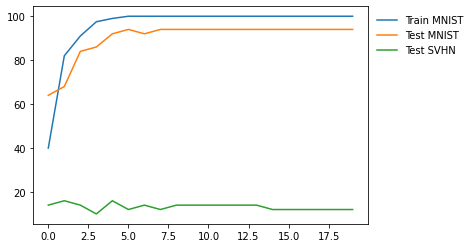

In [15]:
EPOCHS = 20

train_acc = []
test_acc = []
svhn_test_acc = []
for epoch in range(EPOCHS):
    reset_metrics()
    for images, labels in train_ds:
        train_step(images, labels)

    for test_data, svhn_test_data in zip(test_ds,svhn_test_ds):
        test_step(test_data[0], test_data[1], svhn_test_data[0], svhn_test_data[1])

    template = 'Epoch {}, Train Accuracy: {}, Source Test Accuracy: {}, Target Test Accuracy: {}'
    print (template.format(epoch+1,
                           train_accuracy.result()*100,
                           test_accuracy.result()*100,
                           svhn_test_accuracy.result()*100,))
    
    train_acc.append(train_accuracy.result()*100)
    test_acc.append(test_accuracy.result()*100)
    svhn_test_acc.append(svhn_test_accuracy.result()*100)
    
plt.plot(list(range(EPOCHS)), train_acc, label = "Train MNIST")
plt.plot(list(range(EPOCHS)), test_acc, label = "Test MNIST")
plt.plot(list(range(EPOCHS)), svhn_test_acc, label = "Test SVHN")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0),fontsize = 10,frameon=False)
plt.show()    

예측 :  0
정답 :  0


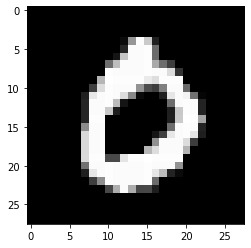

예측 :  2
정답 :  2


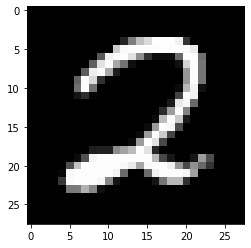

In [16]:
for images, labels in test_ds:
    predictions = model(images)
    print("예측 : ", np.argmax(predictions[3]))
    print("정답 : ", labels[3].numpy())
    plt.imshow(images[3])
    plt.show()

예측 :  0
정답 :  0


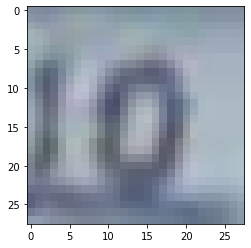

예측 :  0
정답 :  1


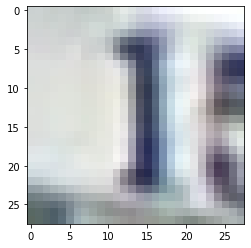

In [17]:
for images, labels in svhn_test_ds:
    predictions = model(images)
    print("예측 : ", np.argmax(predictions[3]))
    print("정답 : ", labels[3].numpy())
    plt.imshow(images[3])
    plt.show()

<a name='section4'></a> 
# 4. Domain adversarial neural network

<img src="https://github.com/MinseokOff/KSME_advanced/blob/main/Pre_trained/dann_arc.png?raw=true" width="700"/>

<a name='section4.1'></a> 
## 4.1 Domain adversarial neural network model, loss, optimizer, metrics
- feature generator
- label predictor 
- domain predictor 

In [18]:
class FeatureGenerator(Model):
    def __init__(self):
        super(FeatureGenerator, self).__init__() 
        self.normalise = lambda x: (tf.cast(x, tf.float64) - channel_mean) / 255.0
        self.conv1 = Conv2D(64, 5, activation='relu')
        self.conv2 = Conv2D(128, 5, activation='relu')
        self.maxpool = MaxPool2D(2)
        self.flatten = Flatten()
    
    def call(self, x):
        x = self.normalise(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool(x)

        return self.flatten(x)

feature_generator = FeatureGenerator()

In [19]:
class LabelPredictor(Model):
    def __init__(self):
        super(LabelPredictor, self).__init__() 
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, feats):  
        feats = self.d1(feats)
        return self.d2(feats)

label_predictor = LabelPredictor()

In [20]:
class DomainPredictor(Model):
    def __init__(self):
        super(DomainPredictor, self).__init__()   
        self.d3 = Dense(64, activation='relu')
        self.d4 = Dense(2, activation='softmax')

    def call(self, feats):
        feats = self.d3(feats)
        return self.d4(feats)

domain_predictor = DomainPredictor()

In [21]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
f_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [22]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

svhn_test_loss = tf.keras.metrics.Mean(name='m_test_loss')
svhn_test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='m_test_accuracy')

In [23]:
conf_train_loss = tf.keras.metrics.Mean(name='c_train_loss')
conf_train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='c_train_accuracy')

<a name='section4.2'></a> 
## 4.2 Domain label generation

In [24]:
x_train_domain_labels = np.ones([len(x_train)])
svhn_train_domain_labels = np.zeros([len(svhn_train_ls)])
all_train_domain_labels = np.hstack((x_train_domain_labels, svhn_train_domain_labels))

domain_train_ds = tf.data.Dataset.from_tensor_slices(
    (all_train_domain_images, tf.cast(all_train_domain_labels, tf.int8))).shuffle(60000).batch(32)

<a name='section4.3'></a> 
## 4.3 Train and Test function

In [25]:
@tf.function
def train_step(images, labels, images2, domains, alpha):
    
    ## Update the generator and the classifier
    with tf.GradientTape(persistent=True) as tape:
        features = feature_generator(images)
        l_predictions = label_predictor(features)
        features = feature_generator(images2)
        d_predictions = domain_predictor(features)
        label_loss = loss_object(labels, l_predictions)
        domain_loss = loss_object(domains, d_predictions)
    
    f_gradients_on_label_loss = tape.gradient(label_loss, feature_generator.trainable_variables)
    f_gradients_on_domain_loss = tape.gradient(domain_loss, feature_generator.trainable_variables)    
    f_gradients = [f_gradients_on_label_loss[i] - alpha*f_gradients_on_domain_loss[i] for i in range(len(f_gradients_on_domain_loss))]

    l_gradients = tape.gradient(label_loss, label_predictor.trainable_variables)
    f_optimizer.apply_gradients(zip(f_gradients+l_gradients, 
                                  feature_generator.trainable_variables+label_predictor.trainable_variables)) 
    
    ## Update the discriminator: Comment this bit to complete all updates in one step. Asynchronous updating 
    with tf.GradientTape() as tape:
        features = feature_generator(images2)
        d_predictions = domain_predictor(features)
        domain_loss = loss_object(domains, d_predictions)
   
    d_gradients = tape.gradient(domain_loss, domain_predictor.trainable_variables)  
    d_gradients = [alpha*i for i in d_gradients]
    d_optimizer.apply_gradients(zip(d_gradients, domain_predictor.trainable_variables))
  
    train_loss(label_loss)
    train_accuracy(labels, l_predictions)
    conf_train_loss(domain_loss)
    conf_train_accuracy(domains, d_predictions)

In [26]:
@tf.function
def test_step(mnist_images, labels, svhn_images, labels2):
    features = feature_generator(mnist_images)
    predictions = label_predictor(features)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

    features = feature_generator(svhn_images)
    predictions = label_predictor(features)
    t_loss = loss_object(labels2, predictions)

    svhn_test_loss(t_loss)
    svhn_test_accuracy(labels2, predictions)

In [27]:
def reset_metrics():
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    svhn_test_loss.reset_states()
    svhn_test_accuracy.reset_states()

<a name='section4.4'></a> 
## 4.4 Train  with MNIST and SVHN

Epoch 1, Train Accuracy: 22.0, Domain Accuracy: 50.44642639160156, Source Test Accuracy: 34.0, Target Test Accuracy: 6.0
Epoch 2, Train Accuracy: 40.0, Domain Accuracy: 52.67857360839844, Source Test Accuracy: 44.0, Target Test Accuracy: 10.0
Epoch 3, Train Accuracy: 27.000001907348633, Domain Accuracy: 50.2976188659668, Source Test Accuracy: 12.0, Target Test Accuracy: 12.0
Epoch 4, Train Accuracy: 26.499998092651367, Domain Accuracy: 50.44642639160156, Source Test Accuracy: 42.0, Target Test Accuracy: 14.0
Epoch 5, Train Accuracy: 58.0, Domain Accuracy: 54.107139587402344, Source Test Accuracy: 72.0, Target Test Accuracy: 12.0
Epoch 6, Train Accuracy: 68.0, Domain Accuracy: 55.20833206176758, Source Test Accuracy: 66.0, Target Test Accuracy: 16.0
Epoch 7, Train Accuracy: 66.5, Domain Accuracy: 55.61224365234375, Source Test Accuracy: 76.0, Target Test Accuracy: 10.0
Epoch 8, Train Accuracy: 82.0, Domain Accuracy: 58.705360412597656, Source Test Accuracy: 70.0, Target Test Accuracy: 1

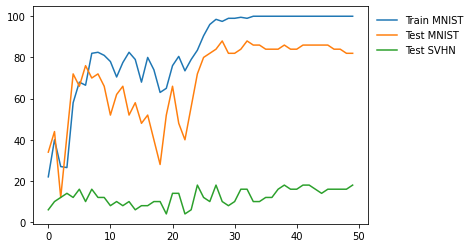

In [28]:
EPOCHS = 50
alpha = 10

train_acc = []
test_acc = []
svhn_test_acc = []
for epoch in range(EPOCHS):
    reset_metrics()

    for domain_data, label_data in zip(domain_train_ds, train_ds):
    
        try:
            train_step(label_data[0], label_data[1], domain_data[0], domain_data[1], alpha=alpha)

        except ValueError: 
            pass
    
    for test_data, svhn_test_data in zip(test_ds, svhn_test_ds):
        test_step(test_data[0], test_data[1], svhn_test_data[0], svhn_test_data[1])
  
    template = 'Epoch {}, Train Accuracy: {}, Domain Accuracy: {}, Source Test Accuracy: {}, Target Test Accuracy: {}'
    print (template.format(epoch+1,
                           train_accuracy.result()*100,
                           conf_train_accuracy.result()*100,
                           test_accuracy.result()*100,
                           svhn_test_accuracy.result()*100,))
    
    train_acc.append(train_accuracy.result()*100)
    test_acc.append(test_accuracy.result()*100)
    svhn_test_acc.append(svhn_test_accuracy.result()*100)
    
plt.plot(list(range(EPOCHS)), train_acc, label = "Train MNIST")
plt.plot(list(range(EPOCHS)), test_acc, label = "Test MNIST")
plt.plot(list(range(EPOCHS)), svhn_test_acc, label = "Test SVHN")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0),fontsize = 10,frameon=False)
plt.show()    

예측 :  0
정답 :  0


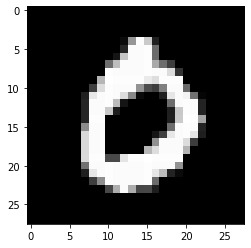

예측 :  2
정답 :  2


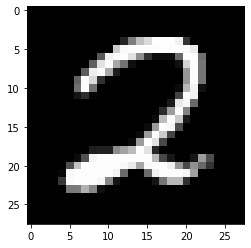

In [29]:
for images, labels in test_ds:
    features = feature_generator(images)
    predictions = label_predictor(features)
    print("예측 : ", np.argmax(predictions[3]))
    print("정답 : ", labels[3].numpy())
    plt.imshow(images[3])
    plt.show()

예측 :  1
정답 :  0


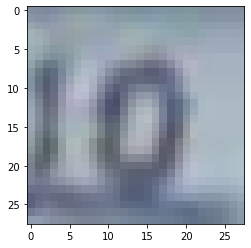

예측 :  0
정답 :  1


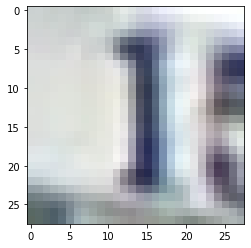

In [30]:
for images, labels in svhn_test_ds:
    features = feature_generator(images)
    predictions = label_predictor(features)
    print("예측 : ", np.argmax(predictions[3]))
    print("정답 : ", labels[3].numpy())
    plt.imshow(images[3])
    plt.show()